In [10]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd

from functions.EpiIndex import *
from functions.Connectivity import *

In [2]:
raw=mne.io.read_raw_fif('.lightning_studio/EpiPlan /data/pte_6_cleaned.fif', preload=True)

Opening raw data file .lightning_studio/EpiPlan /data/pte_6_cleaned.fif...
Isotrak not found
    Range : 1356800 ... 1510400 =   5300.000 ...  5900.000 secs
Ready.
Reading 0 ... 153600  =      0.000 ...   600.000 secs...


/tmp/ipykernel_1641/2121633167.py:1: RuntimeWarning: This filename (.lightning_studio/EpiPlan /data/pte_6_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('.lightning_studio/EpiPlan /data/pte_6_cleaned.fif', preload=True)


In [17]:
data=raw.get_data()
channels=raw.ch_names

In [19]:
df=pd.DataFrame(data,index=channels)
#df.to_csv('Epiplan_dataseries.csv')


In [25]:
df_t=df.transpose()
df_t.to_csv('Epiplan_dataseries_true.csv')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


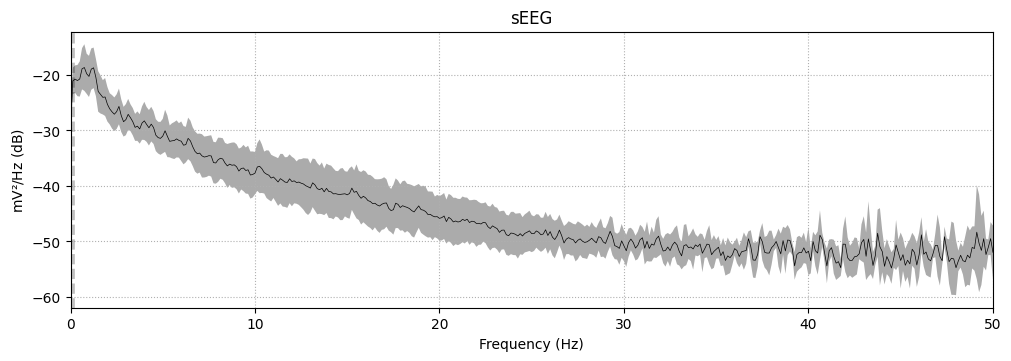

In [3]:
raw.plot_psd(fmax=50, average=True, spatial_colors=False)
plt.show()

In [4]:
#BAnds of interest
bands = {'theta':(3.5, 7.5),
         'alpha': (7.5, 13),
         'beta': (13, 30),
         'gamma': (30, 45)}

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 12800 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_1644/1469543472.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=['OF1'],cmap='RdBu_r')


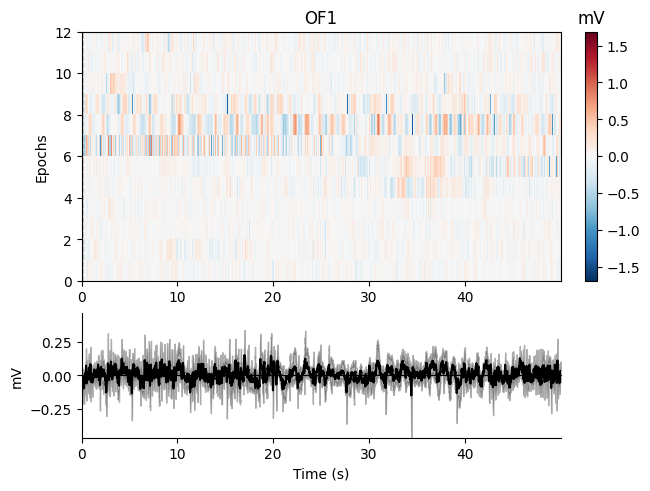

OF: [0, 1, 2, 3, 4, 5]
CR: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
CA: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
CC: [27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
SC: [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
OP: [47, 48, 49, 50, 51, 52, 53]
IP: [54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
PM: [64, 65, 66, 67, 68, 69]
SA: [70, 71, 72, 73, 74, 75, 76, 77]
CP: [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
PA: [90, 91, 92, 93, 94, 95, 96, 97, 98]
I: [99, 100, 101, 102, 103, 104, 105, 106]
B: [107, 108, 109, 110, 111, 112, 113, 114, 115, 116]
C: [117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [6]:
epochs=mne.make_fixed_length_epochs(raw, duration=50.0, preload=True)
epochs.plot_image(picks=['OF1'],cmap='RdBu_r')

# Group channels based on their prefixes
channel_groups = {}
for idx, channel in enumerate(epochs.info['ch_names']):
  prefix = ''.join(filter(str.isalpha, channel))
  if prefix in channel_groups:
    channel_groups[prefix].append(idx)
  else:
    channel_groups[prefix] = [idx]

for prefix, channels in channel_groups.items():
    print(f'{prefix}: {channels}')

In [6]:
#Lets calculate the GC for each band
#Lets begin with theta and let A and B be CC and CA
#A=channel_groups['CC']
#B=channel_groups['CA']
#gc_ab,gc_ba,freqs=calculate_and_plot_granger_causality(epochs, A, B,  fmin=bands['theta'][0], fmax=bands['theta'][1])

In [7]:
#Now, we are going to calculate the cum sum of the values under the y=0 line and over the y=0 line. 
#When a value is over the y=0 line, it means that the channel in A is causing the channel in B
#When a value is under the y=0 line, it means that the channel in B is causing the channel in A
#res=gc_ab.get_data()[0]-gc_ba.get_data()[0]
#A1=0
#A2=0
#for i in range(len(res)):
#    if res[i]>0:
#        A1+=res[i]
#    else:
#        A2+=res[i]
#print(f'The sum of the values over the y=0 line is {A1}')
#print(f'The sum of the values under the y=0 line is {A2}')
        

In [8]:
#MAke a function to calculate the area of two set of channels in a band
def calculate_Area(A,B,epochs,band):
    gc_ab,gc_ba,freqs=calculate_and_plot_granger_causality(epochs, A, B,  fmin=band[0], fmax=band[1],verbose=False,plot=False)
    res=gc_ab.get_data()[0]-gc_ba.get_data()[0]
    A1=0
    A2=0
    for i in range(len(res)):
        if res[i]>0:
            A1+=res[i]
        else:
            A2+=res[i]
    return A1,A2

The area of OF causing CR in band theta is 39.33544833621646
The area of OF causing CA in band theta is 15.16162041807307
The area of OF causing CC in band theta is 14.625692061376256
The area of OF causing SC in band theta is 19.766461560760646
The area of OF causing OP in band theta is 9.542671643718066
The area of OF causing IP in band theta is 20.562029693167062
The area of OF causing PM in band theta is 43.48848197793403
The area of OF causing SA in band theta is 20.38745984459237
The area of OF causing CP in band theta is 6.60272106310147
The area of OF causing PA in band theta is 22.019468096263523
The area of OF causing I in band theta is 24.060983333041364
The area of OF causing B in band theta is 9.116191730874476
The area of OF causing C in band theta is 4.111074876544848
The area of CR causing OF in band theta is 15.937145177757856
The area of CR causing CA in band theta is 18.962209712505327
The area of CR causing CC in band theta is 16.385653540486842
The area of CR causi

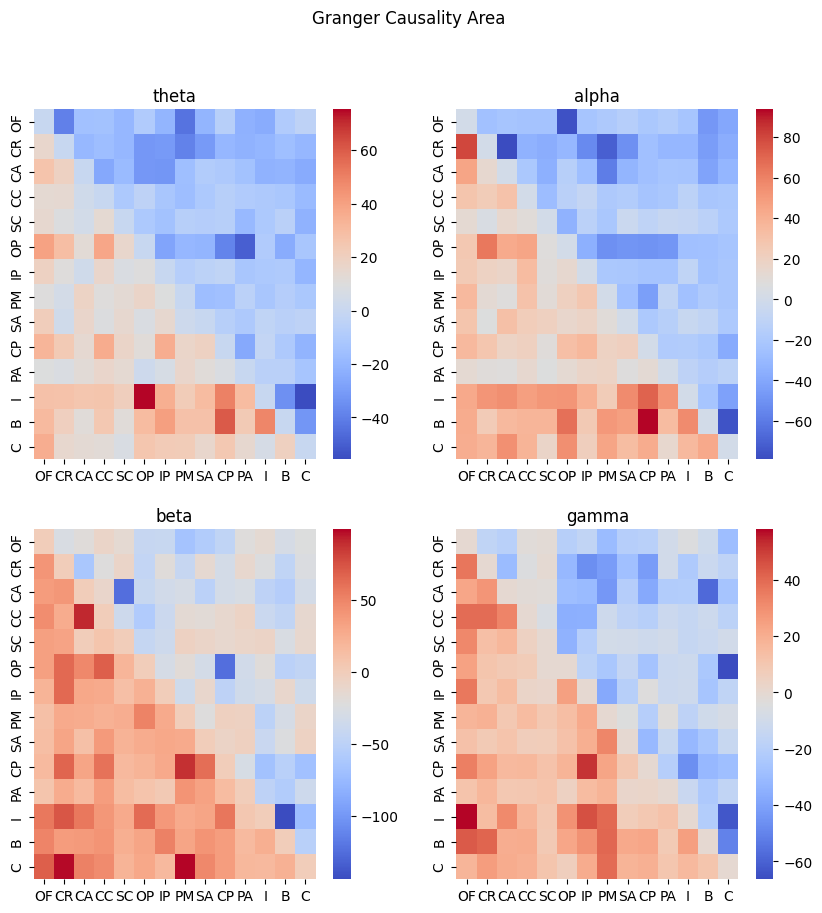

In [12]:
#Lets calculate the area for all the bands and put them in a matrix. The matrix has the shape of the number of prefixes
#by the number of prefixes
matrix=np.zeros((len(channel_groups.keys()),len(channel_groups.keys()),4))

for i,band in enumerate(bands.keys()):
    for j,prefix1 in enumerate(channel_groups.keys()):
        for k,prefix2 in enumerate(channel_groups.keys()):
            if j==k:
                matrix[j,k,i]=0
                continue
            A=channel_groups[prefix1]
            B=channel_groups[prefix2]
            A1,A2=calculate_Area(A,B,epochs,bands[band])
            matrix[j,k,i]=A1
            matrix[k,j,i]=A2
            print(f'The area of {prefix1} causing {prefix2} in band {band} is {A1}')


#Now we are going to plot the matrix
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Granger Causality Area')
for i,band in enumerate(bands.keys()):
    sns.heatmap(matrix[:,:,i], ax=axs[i//2,i%2], xticklabels=channel_groups.keys(), yticklabels=channel_groups.keys(), cmap='coolwarm')
    axs[i//2,i%2].set_title(band)
plt.show()


In [15]:
#Save the matrix in a csv file
np.savetxt('GC_Area_theta.csv', matrix[:,:,0], delimiter=',')
np.savetxt('GC_Area_alpha.csv', matrix[:,:,1], delimiter=',')
np.savetxt('GC_Area_beta.csv', matrix[:,:,2], delimiter=',')
np.savetxt('GC_Area_gamma.csv', matrix[:,:,3], delimiter=',')


In [5]:
matrix_theta=np.loadtxt('/teamspace/studios/this_studio/GC_Area_alpha.csv', delimiter=',')
matrix_alpha=np.loadtxt('/teamspace/studios/this_studio/GC_Area_alpha.csv', delimiter=',')
matrix_beta=np.loadtxt('/teamspace/studios/this_studio/GC_Area_beta.csv', delimiter=',')
matrix_gamma=np.loadtxt('/teamspace/studios/this_studio/GC_Area_gamma.csv', delimiter=',')

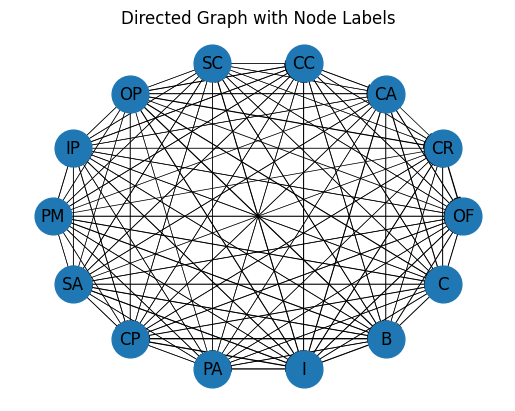

In [24]:
node_names=list(channel_groups.keys())

# Convert numpy matrix to a NetworkX graph
G = nx.DiGraph(matrix_theta)

# Normalize edge weights
edge_weights = np.array([G[u][v]['weight'] for u,v in G.edges()])
max_weight = np.max(edge_weights)
min_weight = np.min(edge_weights)
normalized_weights = (edge_weights - min_weight) / (max_weight - min_weight)

# Draw the graph with improved layout
pos = nx.circular_layout(G)  # Positions for all nodes

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# Draw edges with normalized thickness
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos, arrows=True, width=normalized_weights)



# Draw labels
node_labels = {i: node_names[i] for i in range(len(node_names))}
nx.draw_networkx_labels(G, pos, labels=node_labels)


# Display the graph
plt.title("Directed Graph with Node Labels")
plt.axis("off")
plt.show()


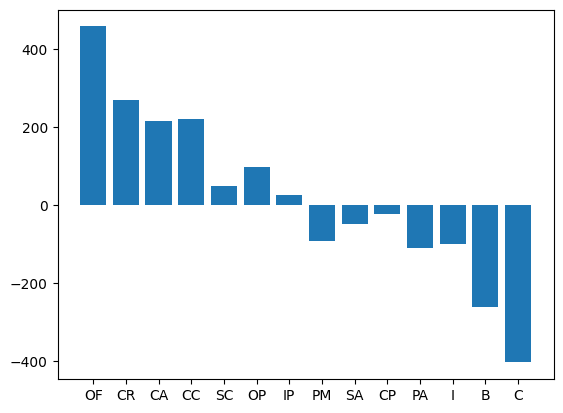

In [27]:
#Mak3 the sum over every row, and plot a bar plot only for theta
sums=np.sum(matrix_theta,axis=0)
plt.bar(channel_groups.keys(),sums)
plt.show()

#Interpreta

In [ ]:
#Mak3 the sum over every row, and plot a bar plot
sums=np.sum(matrix, axis=1)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Granger Causality Area Sum')
for i,band in enumerate(bands.keys()):
    axs[i//2,i%2].bar(channel_groups.keys(),sums[:,i])
    axs[i//2,i%2].set_title(band)
plt.show()